In [100]:
import webrtcvad
import librosa
import numpy as np
import soundfile as sf
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import joblib

### Suppression du silence et Extraction de MFCC

In [103]:
def frame_generator(audio, sr, frame_duration_ms=30):
    """Découpe l'audio en frames de `frame_duration_ms` ms (10, 20 ou 30 ms)."""
    frame_size = int(sr * frame_duration_ms / 1000)  # Taille de la frame en échantillons
    frames = [audio[i:i + frame_size] for i in range(0, len(audio), frame_size)]
    
    # Filtrer les frames incomplètes
    return [frame for frame in frames if len(frame) == frame_size]

def float_to_pcm16(audio_float):
    """Convertit un signal float32 (-1 à 1) en PCM 16 bits (-32768 à 32767)."""
    audio_int16 = np.int16(audio_float * 32767)  # Conversion en int16
    return audio_int16.tobytes()

def vad_filter(audio, sr, frame_duration_ms=30, mode=3):
    """Supprime le silence en utilisant WebRTC VAD."""
    vad = webrtcvad.Vad(mode)  # Mode 0-3, plus élevé = plus strict
    frames = frame_generator(audio, sr, frame_duration_ms)
    
    # Vérifier que l'échantillonnage est bien supporté
    if sr not in [8000, 16000, 32000, 48000]:
        raise ValueError("WebRTC VAD supporte uniquement les fréquences 8kHz, 16kHz, 32kHz, 48kHz.")

    # Convertir chaque frame en PCM 16 bits avant le traitement
    voiced_frames = [frame for frame in frames if vad.is_speech(float_to_pcm16(frame), sr)]
    
    return np.concatenate(voiced_frames) if voiced_frames else np.array([])

In [105]:
def extract_mfcc(audio, sr, n_mfcc=13, energy_threshold=0.01):
    """Extract MFCCs, remove low-energy frames, and drop the first coefficient (energy)."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc[1:, :]  # Remove the first coefficient (energy)

    return mfcc

In [107]:
def process_audio_files(input_dir, output_dir, output_mfcc_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".wav"):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)
                
                # Replace .wav with .mfcc for saving the MFCC file
                output_mfcc_path = os.path.join(output_mfcc_dir, relative_path.replace(".wav", ".mfcc"))
                
                # Create necessary output folders
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                os.makedirs(os.path.dirname(output_mfcc_path), exist_ok=True)
                
                # Load the audio
                y, sr = librosa.load(input_path, sr=16000)  # 16kHz for WebRTC VAD
                
                # Apply VAD to remove silence
                y_clean = vad_filter(y, sr)
                
                # Save the processed audio file (silence removed)
                sf.write(output_path, y_clean, sr)
                print(f"Processed: {output_path}")

                # Extract MFCCs from the cleaned audio (y_clean)
                mfcc_features = extract_mfcc(y_clean, sr)

                # Save the MFCC features in a human-readable .mfcc format
                np.savetxt(output_mfcc_path, mfcc_features, delimiter=",")  
                print(f"MFCC saved: {output_mfcc_path}")

In [109]:
INPUT_DIR = r"C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\Reconnaissance_du_locuteur"
OUTPUT_DIR = r"C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\Reconnaissance_du_locuteur_sb"
OUTPUT_MFCC_DIR = r"C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\MFCC"
process_audio_files(INPUT_DIR, OUTPUT_DIR, OUTPUT_MFCC_DIR)

Processed: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\Reconnaissance_du_locuteur_sb\F1\Test\10s\Seg1.wav
MFCC saved: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\MFCC\F1\Test\10s\Seg1.mfcc
Processed: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\Reconnaissance_du_locuteur_sb\F1\Test\10s\Seg2.wav
MFCC saved: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\MFCC\F1\Test\10s\Seg2.mfcc
Processed: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\Reconnaissance_du_locuteur_sb\F1\Test\10s\Seg3.wav
MFCC saved: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\MFCC\F1\Test\10s\Seg3.mfcc
Processed: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\Reconnaissance_du_locuteur_sb\F1\Test\10s\Seg4.wav
MFCC saved: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\MFCC\F1\Test\10s\Seg4.mfcc
Processed: C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_

### Création du modèle GMM

In [111]:
def load_mfcc_for_speaker(train_mfcc_path):
    """Load the MFCC file for a speaker from the 'Train' folder."""
    for file in os.listdir(train_mfcc_path):
        if file.endswith(".mfcc"):  # Ensure correct format
            file_path = os.path.join(train_mfcc_path, file)
            return np.loadtxt(file_path, delimiter=",").T  # Load & transpose MFCC

    return None  # Return None if no valid MFCC file is found

def train_gmm_for_speakers(mfcc_dir,output_dir, n_components_list=[8, 16, 32, 64, 128, 256]):
    """Train GMM models for each speaker using only the 'Train' folder MFCC."""
    
    speakers = os.listdir(mfcc_dir)  # Each folder is a speaker

    for speaker in speakers:
        train_path = os.path.join(mfcc_dir, speaker, "Train")  # Only use Train folder
        model_dir = os.path.join(output_dir, speaker)  # Save models in MFCC/{speaker}/Model/
        os.makedirs(model_dir, exist_ok=True)  # Create model directory if needed
        
        mfcc_features = load_mfcc_for_speaker(train_path)
        
        if mfcc_features is None:
            print(f"Skipping {speaker}, no MFCC data found in Train folder.")
            continue
        
        for n_components in n_components_list:
            gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42)
            gmm.fit(mfcc_features)  # Train the model
            
            model_filename = os.path.join(model_dir, f"{speaker}_{n_components}.gmm")
            joblib.dump(gmm, model_filename)  # Save model
            print(f"Saved GMM model for {speaker} with {n_components} components at {model_filename}") 

In [112]:
mfcc_dir = r"C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\MFCC"
output_dir = r"C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM"
train_gmm_for_speakers(mfcc_dir,output_dir)

Saved GMM model for F1 with 8 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM\F1\F1_8.gmm
Saved GMM model for F1 with 16 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM\F1\F1_16.gmm
Saved GMM model for F1 with 32 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM\F1\F1_32.gmm
Saved GMM model for F1 with 64 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM\F1\F1_64.gmm
Saved GMM model for F1 with 128 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM\F1\F1_128.gmm
Saved GMM model for F1 with 256 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM\F1\F1_256.gmm
Saved GMM model for F10 with 8 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM\F10\F10_8.gmm
Saved GMM model for F10 with 16 components at C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Proje

In [120]:
def load_test_mfccs(base_dir, duration):
    """Load all test MFCCs for a specific duration (5s, 10s, or 15s)"""
    test_mfccs = {}
    
    for speaker in os.listdir(base_dir):
        speaker_path = os.path.join(base_dir, speaker)
        if not os.path.isdir(speaker_path):
            continue
        
        test_dir = os.path.join(speaker_path, "test", duration)  # <-- corrigé "Test" → "test"
        if not os.path.exists(test_dir):
            continue
        
        segments = []
        for seg in range(1, 6):  # segments 1 to 5
            mfcc_file = os.path.join(test_dir, f"seg{seg}.mfcc")  # <-- corrigé f"{speaker}_{seg}.mfcc"
            if os.path.exists(mfcc_file):
                try:
                    mfcc = np.loadtxt(mfcc_file, delimiter=",").T
                    segments.append(mfcc)
                except Exception as e:
                    print(f"Erreur lors du chargement de {mfcc_file} : {e}")
        if segments:
            test_mfccs[speaker] = segments
            
    return test_mfccs

def get_gender(speaker):
    """Return 'F' for female speakers, 'H' for male speakers"""
    return 'F' if speaker.startswith('F') else 'H'

def test_models(base_dir, models_dir, duration, output_excel_path):
    """Test all models against test segments of specific duration"""
    test_mfccs = load_test_mfccs(base_dir, duration)
    
    columns = ['Locuteur', 'Identité testé', 'Segment', 'GMMs', 'Score']
    results = []
    
    all_speakers = sorted(test_mfccs.keys())
    female_speakers = [s for s in all_speakers if get_gender(s) == 'F']
    male_speakers = [s for s in all_speakers if get_gender(s) == 'H']
    
    gmm_components = [8, 16, 32, 64, 128, 256]
    
    for test_speaker in all_speakers:
        print(f"Processing test speaker: {test_speaker} ({duration})")
        
        compare_speakers = female_speakers if get_gender(test_speaker) == 'F' else male_speakers
        test_segments = test_mfccs[test_speaker]
        
        for n_components in gmm_components:
            for seg_idx, segment_mfcc in enumerate(test_segments, 1):
                for model_speaker in compare_speakers:
                    model_path = os.path.join(models_dir, model_speaker, f"{model_speaker}_{n_components}.gmm")
                    if not os.path.exists(model_path):
                        continue
                    
                    try:
                        gmm = joblib.load(model_path)
                        score = gmm.score(segment_mfcc)
                        results.append([
                            test_speaker,
                            model_speaker,
                            f"seg{seg_idx}",
                            n_components,
                            score
                        ])
                    except Exception as e:
                        print(f"Erreur lors du test {model_speaker} sur {test_speaker} (seg{seg_idx}, {n_components}) : {e}")
    
    df = pd.DataFrame(results, columns=columns)
    df.to_excel(output_excel_path, index=False)
    print(f"Résultats sauvegardés dans {output_excel_path} ({len(df)} lignes)")

In [124]:
# === Paramètres ===
BASE_DIR = r"C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\MFCC"  # Dossier contenant F1, F2, ..., H10
MODELS_DIR = r"C:\Users\DELL\Desktop\S8\Synthese vocal KHARROUBI\Projet_methode2\GMM"  # Dossier contenant les modèles GMM

OUTPUT_5S = "test_results2_5s.xlsx"
OUTPUT_10S = "test_results2_10s.xlsx"
OUTPUT_15S = "test_results2_15s.xlsx"

# === Lancement des tests pour 3 durées ===
test_models(BASE_DIR, MODELS_DIR, "5s", OUTPUT_5S)
test_models(BASE_DIR, MODELS_DIR, "10s", OUTPUT_10S)
test_models(BASE_DIR, MODELS_DIR, "15s", OUTPUT_15S)

Processing test speaker: F1 (5s)
Processing test speaker: F10 (5s)
Processing test speaker: F11 (5s)
Processing test speaker: F12 (5s)
Processing test speaker: F13 (5s)
Processing test speaker: F2 (5s)
Processing test speaker: F3 (5s)
Processing test speaker: F4 (5s)
Processing test speaker: F5 (5s)
Processing test speaker: F6 (5s)
Processing test speaker: F7 (5s)
Processing test speaker: F8 (5s)
Processing test speaker: F9 (5s)
Processing test speaker: H1 (5s)
Processing test speaker: H10 (5s)
Processing test speaker: H11 (5s)
Processing test speaker: H2 (5s)
Processing test speaker: H3 (5s)
Processing test speaker: H4 (5s)
Processing test speaker: H5 (5s)
Processing test speaker: H6 (5s)
Processing test speaker: H7 (5s)
Processing test speaker: H8 (5s)
Processing test speaker: H9 (5s)
Résultats sauvegardés dans test_results2_5s.xlsx (8700 lignes)
Processing test speaker: F1 (10s)
Processing test speaker: F10 (10s)
Processing test speaker: F11 (10s)
Processing test speaker: F12 (10s)


In [40]:
def identify_speakers(results_excel_path, output_excel_path):
    """À partir des scores, identifier les locuteurs pour chaque segment"""
    df = pd.read_excel(results_excel_path)

    # Groupement par locuteur, segment, et nombre de composantes
    grouped = df.groupby(['Locuteur', 'Segment', 'GMMs'])

    identification_results = []

    for (test_speaker, segment, n_components), group in grouped:
        # On cherche le modèle ayant obtenu le meilleur score
        best_row = group.loc[group['Score'].idxmax()]
        identified_speaker = best_row['Identité testé']
        best_score = best_row['Score']
        
        identification_results.append([
            test_speaker,
            segment,
            n_components,
            identified_speaker,
            best_score
        ])

    result_df = pd.DataFrame(identification_results, columns=[
        'Locuteur', 'Segment', 'GMMs', 'Identité prédite', 'Score max'
    ])

    result_df.to_excel(output_excel_path, index=False)
    print(f"Fichier d'identification généré : {output_excel_path} ({len(result_df)} lignes)")

In [126]:
identify_speakers("test_results2_5s.xlsx", "identification2_5s.xlsx")
identify_speakers("test_results2_10s.xlsx", "identification2_10s.xlsx")
identify_speakers("test_results2_15s.xlsx", "identification2_15s.xlsx")

Fichier d'identification généré : identification2_5s.xlsx (720 lignes)
Fichier d'identification généré : identification2_10s.xlsx (720 lignes)
Fichier d'identification généré : identification2_15s.xlsx (720 lignes)


In [128]:
def calculate_accuracy_curve(file_path):
    """Calcule le taux de bonne identification pour chaque valeur de GMMs"""
    df = pd.read_excel(file_path)
    df['Correct'] = df['Locuteur'] == df['Identité prédite']
    
    accuracy_per_gmm = df.groupby('GMMs')['Correct'].mean().reset_index()
    accuracy_per_gmm.columns = ['GMMs', 'Taux de bonne identification']
    return accuracy_per_gmm

In [159]:
def plot_all_durations(acc_5s, acc_10s, acc_15s):
    """Trace les 3 courbes avec axe X fixe"""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    durations = ['5 secondes', '10 secondes', '15 secondes']
    all_acc = [acc_5s, acc_10s, acc_15s]

    for ax, acc, title in zip(axs, all_acc, durations):
        ax.plot(acc['GMMs'], acc['Taux de bonne identification'], marker='o')
        ax.set_title(f"Les audios de {title}")
        ax.set_xlabel("Nombre de gaussiennes")
        ax.set_ylabel("Taux de bonne identification")
        ax.set_ylim(0, 1)
        ax.set_xticks([8, 16, 32, 64, 128, 256])  # ⬅️ fixe les ticks de l'axe X
        ax.grid(True)

    plt.suptitle("Figure 1 : Taux de bonne identification en fonction du nombre de gaussiennes utilisées pour l'entraînement du modèle.")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

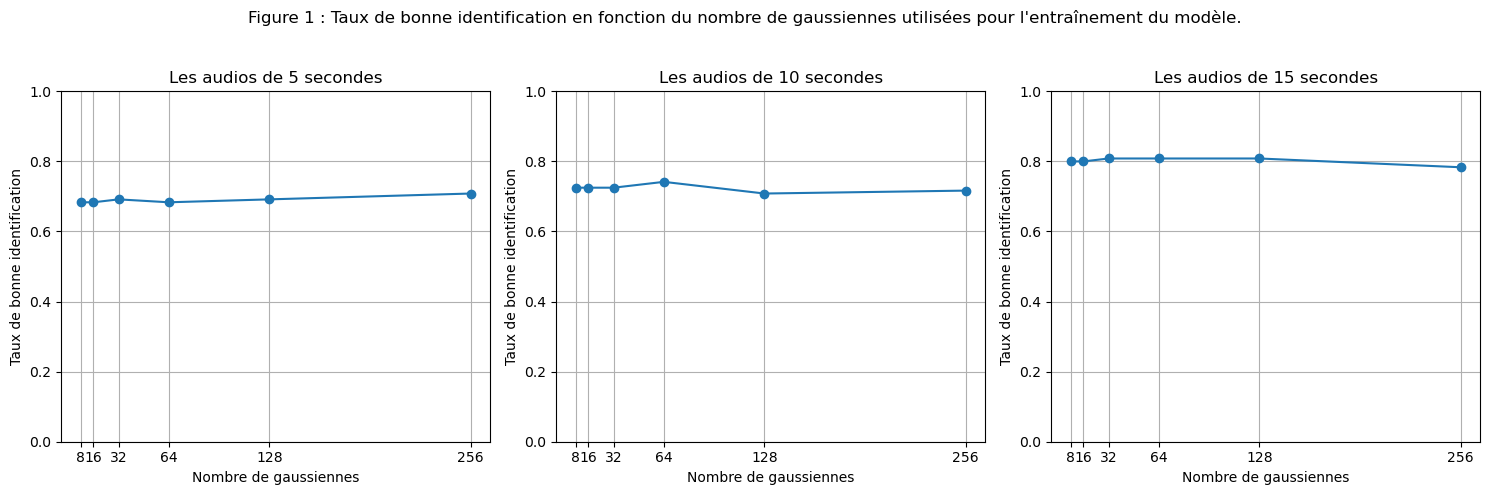

In [161]:
acc_5s = calculate_accuracy_curve("identification2_5s.xlsx")
acc_10s = calculate_accuracy_curve("identification2_10s.xlsx")
acc_15s = calculate_accuracy_curve("identification2_15s.xlsx")
plot_all_durations(acc_5s, acc_10s, acc_15s)

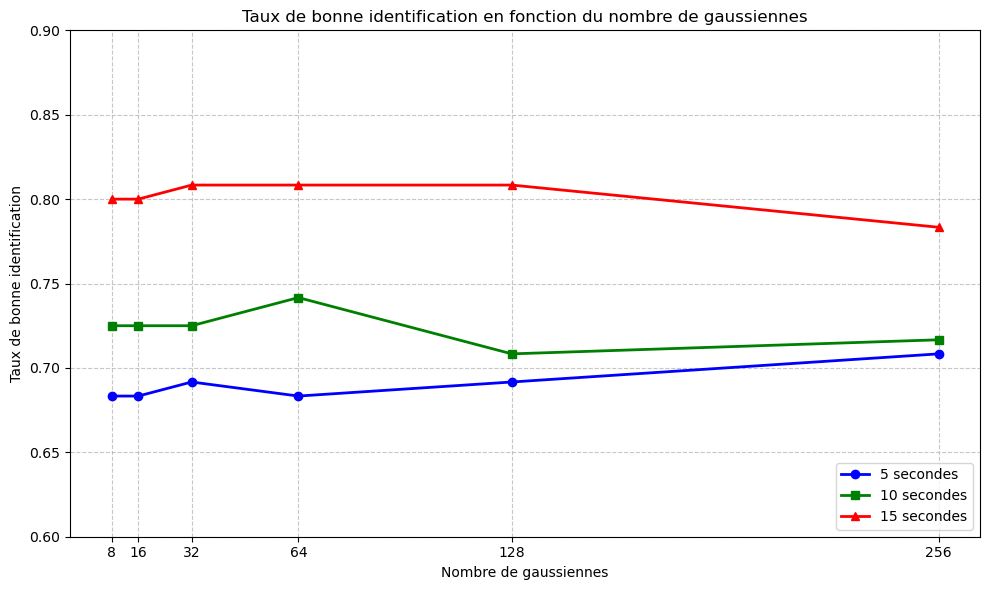

In [167]:
def plot_combined_durations(acc_5s, acc_10s, acc_15s):
    """Trace les 3 courbes sur une seule figure avec Y entre 0.6 et 1"""
    plt.figure(figsize=(10, 6))

    # Couleurs et marqueurs pour chaque durée
    durations = ['5 secondes', '10 secondes', '15 secondes']
    colors = ['blue', 'green', 'red']
    markers = ['o', 's', '^']  # Cercles, carrés, triangles

    # Tracer chaque courbe
    for acc, color, marker, label in zip([acc_5s, acc_10s, acc_15s], colors, markers, durations):
        plt.plot(acc['GMMs'], acc['Taux de bonne identification'], 
                 marker=marker, color=color, label=label, linewidth=2)

    # Configuration du graphique
    plt.title("Taux de bonne identification en fonction du nombre de gaussiennes")
    plt.xlabel("Nombre de gaussiennes")
    plt.ylabel("Taux de bonne identification")
    plt.ylim(0.6, 0.9)  # ⬅️ Axe Y entre 0.6 et 1
    plt.xticks([8, 16, 32, 64, 128, 256])
    plt.grid(True, linestyle='--', alpha=0.7)  # Grille en pointillés
    plt.legend(loc='lower right')  # Légende en bas à droite

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
acc_5s = calculate_accuracy_curve("identification2_5s.xlsx")
acc_10s = calculate_accuracy_curve("identification2_10s.xlsx")
acc_15s = calculate_accuracy_curve("identification2_15s.xlsx")
plot_combined_durations(acc_5s, acc_10s, acc_15s)

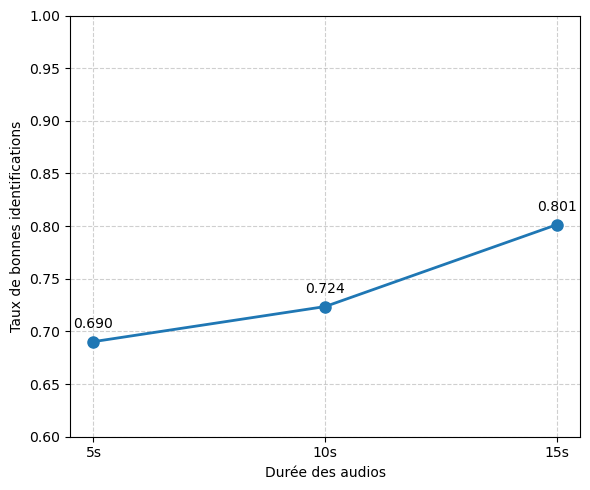

In [176]:
def calculate_overall_accuracy(file_path):
    """Retourne le taux de bonne identification global d’un fichier"""
    df = pd.read_excel(file_path)
    df['Correct'] = df['Locuteur'] == df['Identité prédite']
    return df['Correct'].mean()

# === Calcul pour chaque durée ===
acc_5s = calculate_overall_accuracy("identification2_5s.xlsx")
acc_10s = calculate_overall_accuracy("identification2_10s.xlsx")
acc_15s = calculate_overall_accuracy("identification2_15s.xlsx")

# === Données pour le graphique ===
durations = ['5s', '10s', '15s']
accuracies = [acc_5s, acc_10s, acc_15s]

# === Tracé ===
plt.figure(figsize=(6, 5))
plt.plot(durations, accuracies, marker='o', linewidth=2, markersize=8)

# Personnalisation du graphique
plt.xlabel("Durée des audios")
plt.ylabel("Taux de bonnes identifications")
plt.ylim(0.6, 1)  # ⬅️ Plage Y fixée entre 0.6 et 1
plt.grid(True, linestyle='--', alpha=0.6)

# Ajout des valeurs exactes au-dessus des points
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', va='bottom')  # +0.01 pour décaler vers le haut

plt.tight_layout()
plt.show()

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_det_data(file_path, gmm_components=None):
    df = pd.read_excel(file_path)
    
    # Filtrer par nombre de Gaussiennes si spécifié
    if gmm_components is not None:
        df = df[df['GMMs'] == gmm_components]
    
    # Scores vrais (matching) et faux (non-matching)
    df['Correct'] = df['Locuteur'] == df['Identité testé']
    scores_vrais = df[df['Correct']]['Score'].values
    scores_faux = df[~df['Correct']]['Score'].values
    
    # Création d'une grille de seuils
    all_scores = np.concatenate([scores_vrais, scores_faux])
    seuils = np.linspace(min(all_scores), max(all_scores), 200)
    
    FPR, FNR = [], []
    for seuil in seuils:
        fa = np.mean(scores_faux >= seuil)  # Faux acceptés
        fr = np.mean(scores_vrais < seuil)  # Vrais rejetés
        FPR.append(fa)
        FNR.append(fr)

    return seuils, FPR, FNR

def plot_det(seuils, FPR, FNR, title, ax):
    diff = np.abs(np.array(FPR) - np.array(FNR))
    idx_eer = np.argmin(diff)
    eer_seuil = seuils[idx_eer]
    eer_val = FPR[idx_eer]

    # Formatage des valeurs pour l'affichage
    eer_seuil_text = f"{eer_seuil:.2f}"
    eer_val_text = f"{eer_val*100:.1f}%"
    
    # Courbes DET
    ax.plot(seuils, FPR, label="FA (Faux Acceptions)", color="blue")
    ax.plot(seuils, FNR, label="FR (Faux Rejets)", color="orange")
    
    # Ligne EER
    ax.axvline(eer_seuil, linestyle="--", color="red", 
               label=f"Seuil EER = {eer_seuil_text}\nEER = {eer_val_text}")
    ax.scatter(eer_seuil, eer_val, color="red")
    
    # Annotation du point EER
    ax.annotate(f'Seuil optimal\n{eer_seuil_text}\n(EER={eer_val_text})',
                xy=(eer_seuil, eer_val),
                xytext=(0.6, 0.4),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                bbox=dict(boxstyle="round", fc="w"))

    ax.set_title(title, pad=20)
    ax.set_xlabel("Seuil de décision")
    ax.set_ylabel("Taux d'erreur")
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

def plot_dets_for_gmm(gmm_components):
    durations = ["5s", "10s", "15s"]
    files = ["test_results2_5s.xlsx", "test_results2_10s.xlsx", "test_results2_15s.xlsx"]

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, (d, f) in enumerate(zip(durations, files)):
        try:
            seuils, FPR, FNR = compute_det_data(f, gmm_components)
            plot_det(seuils, FPR, FNR, f"DET Curve - {d} Samples\n{gmm_components} Gaussiennes", axs[i])
        except Exception as e:
            print(f"Erreur avec le fichier {f}: {str(e)}")
            axs[i].set_title(f"Erreur - {d}")
            axs[i].text(0.5, 0.5, "Données non disponibles", 
                       ha='center', va='center')
    
    plt.suptitle(f"Courbes DET avec Seuils Optimaux - {gmm_components} Gaussiennes", 
                fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

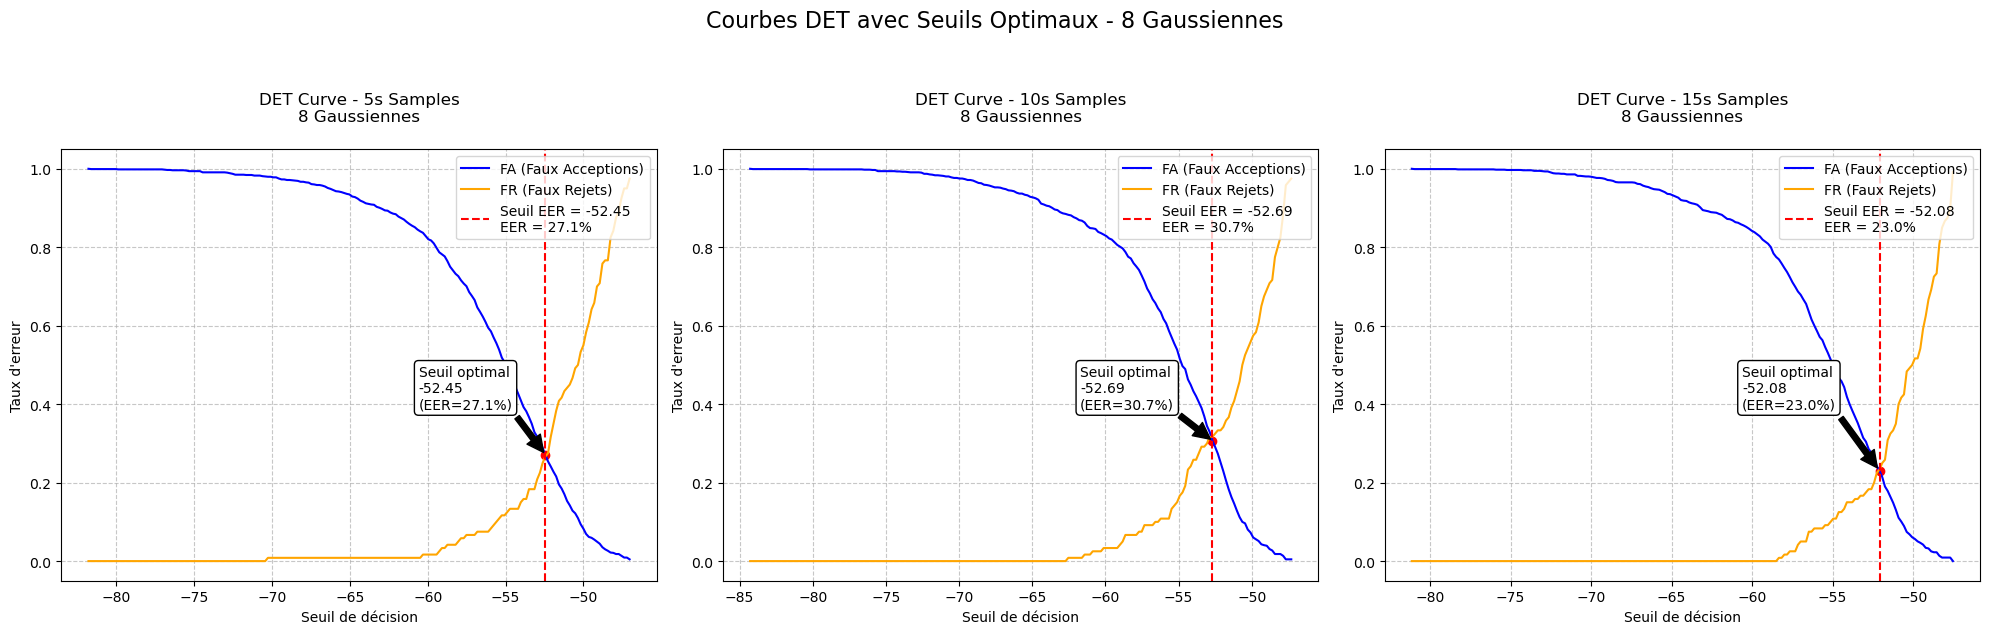

In [138]:
plot_dets_for_gmm(8)  

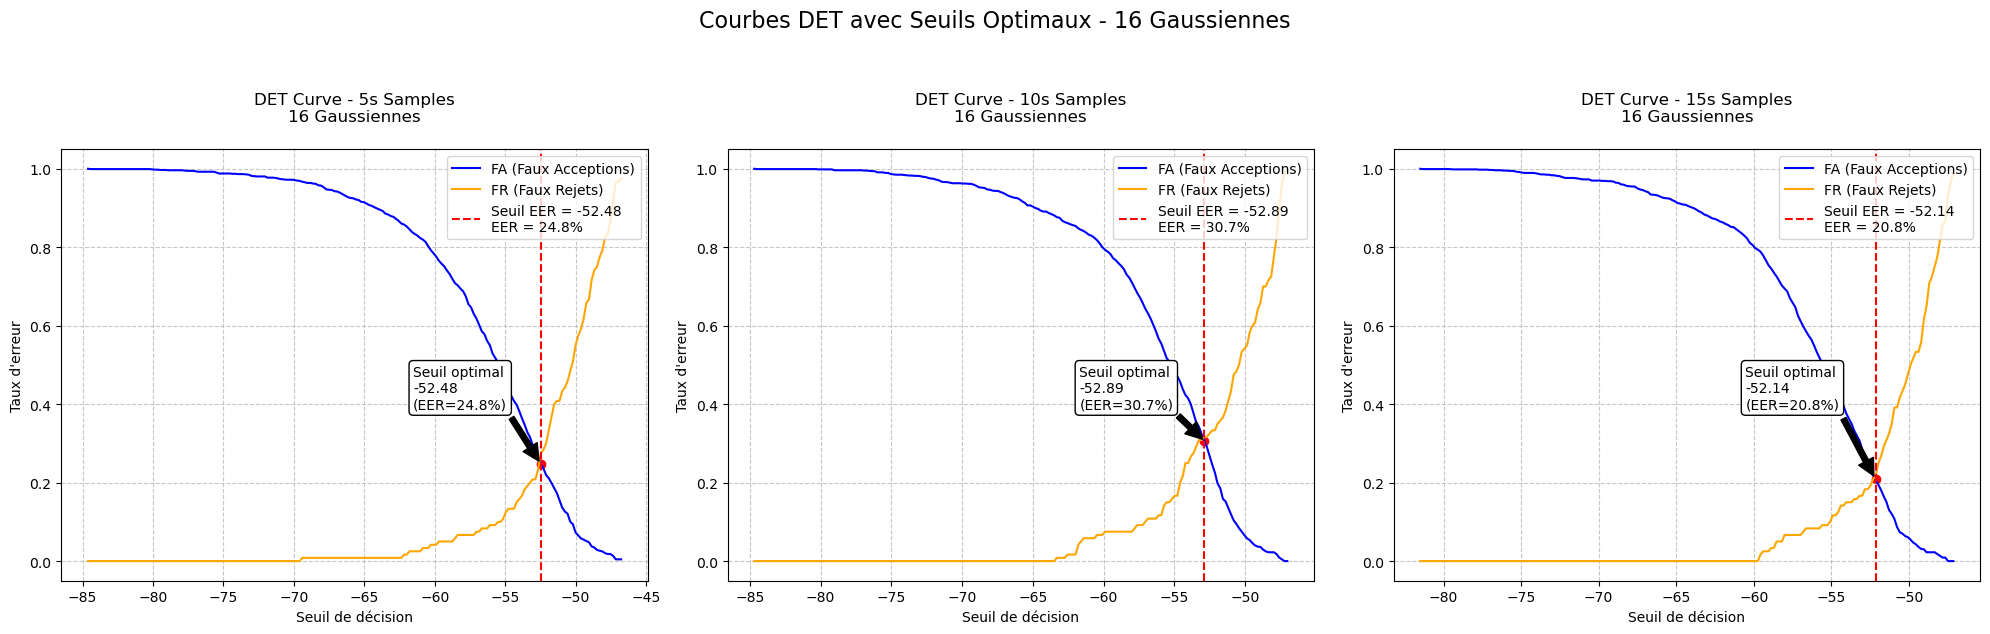

In [140]:
plot_dets_for_gmm(16)  

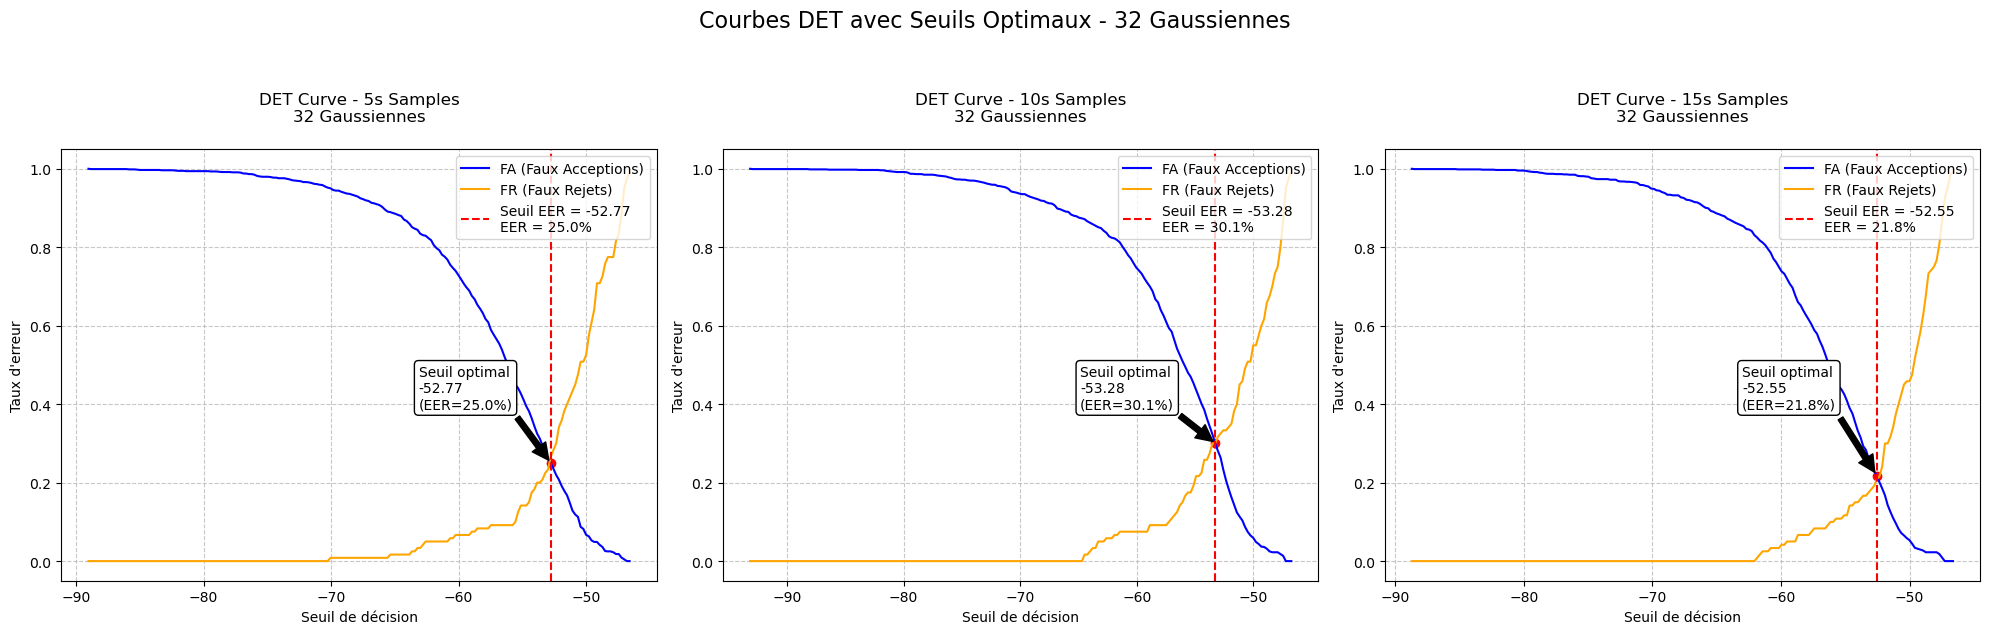

In [141]:
plot_dets_for_gmm(32)  

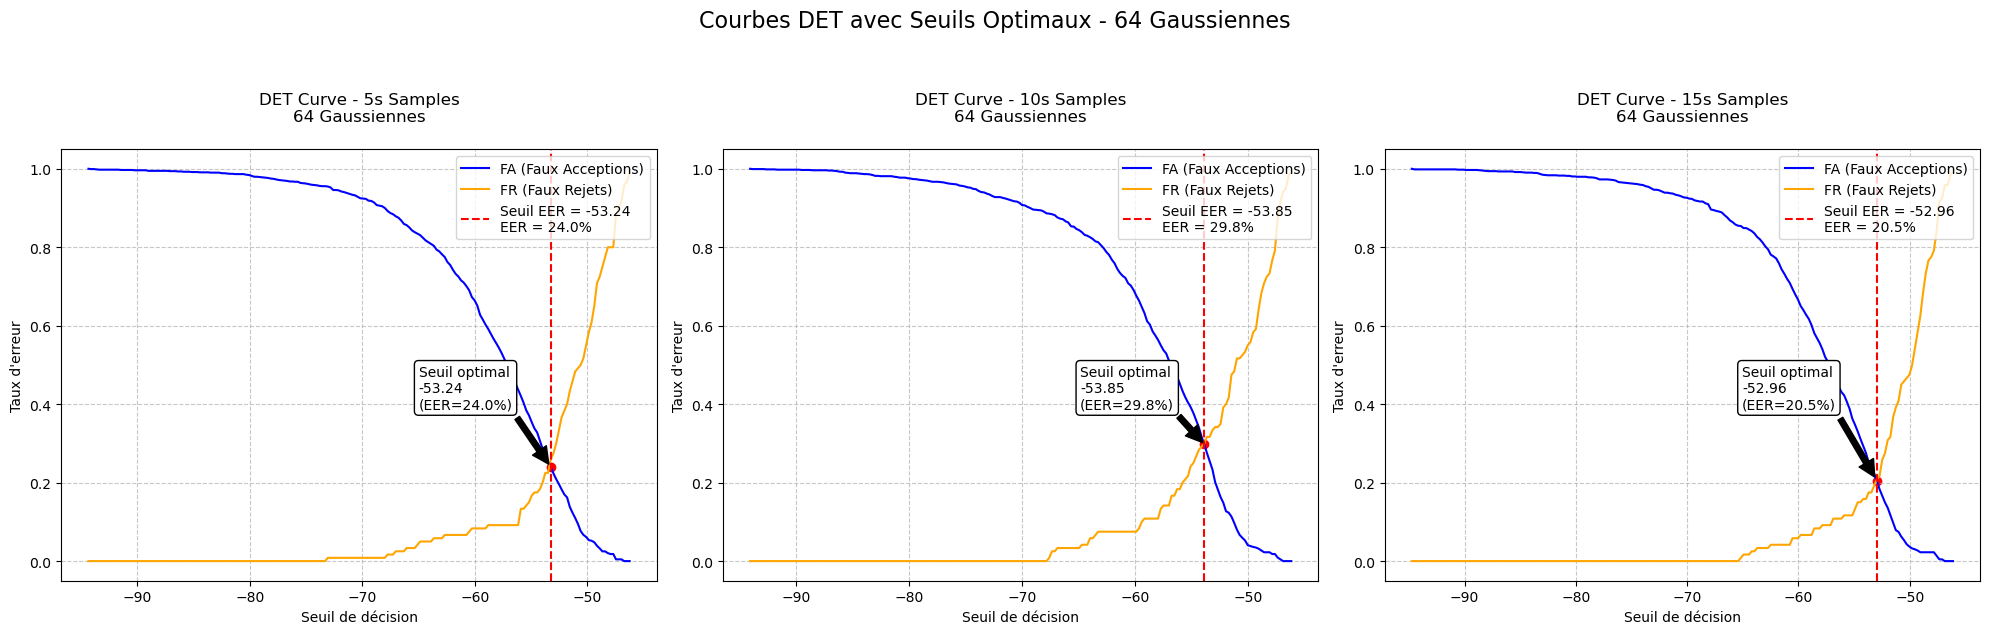

In [142]:
plot_dets_for_gmm(64)  

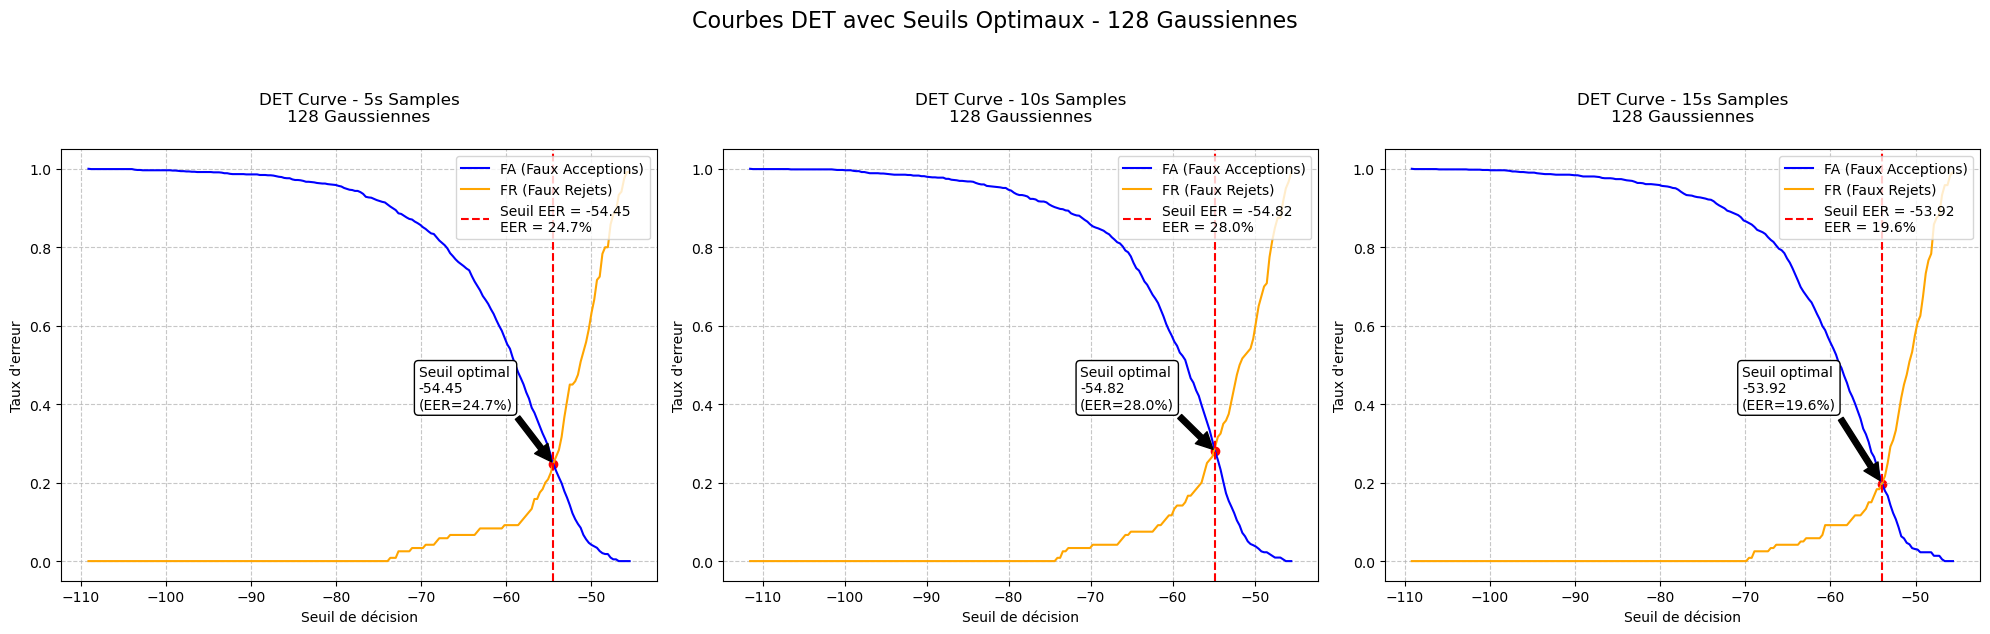

In [143]:
plot_dets_for_gmm(128)  

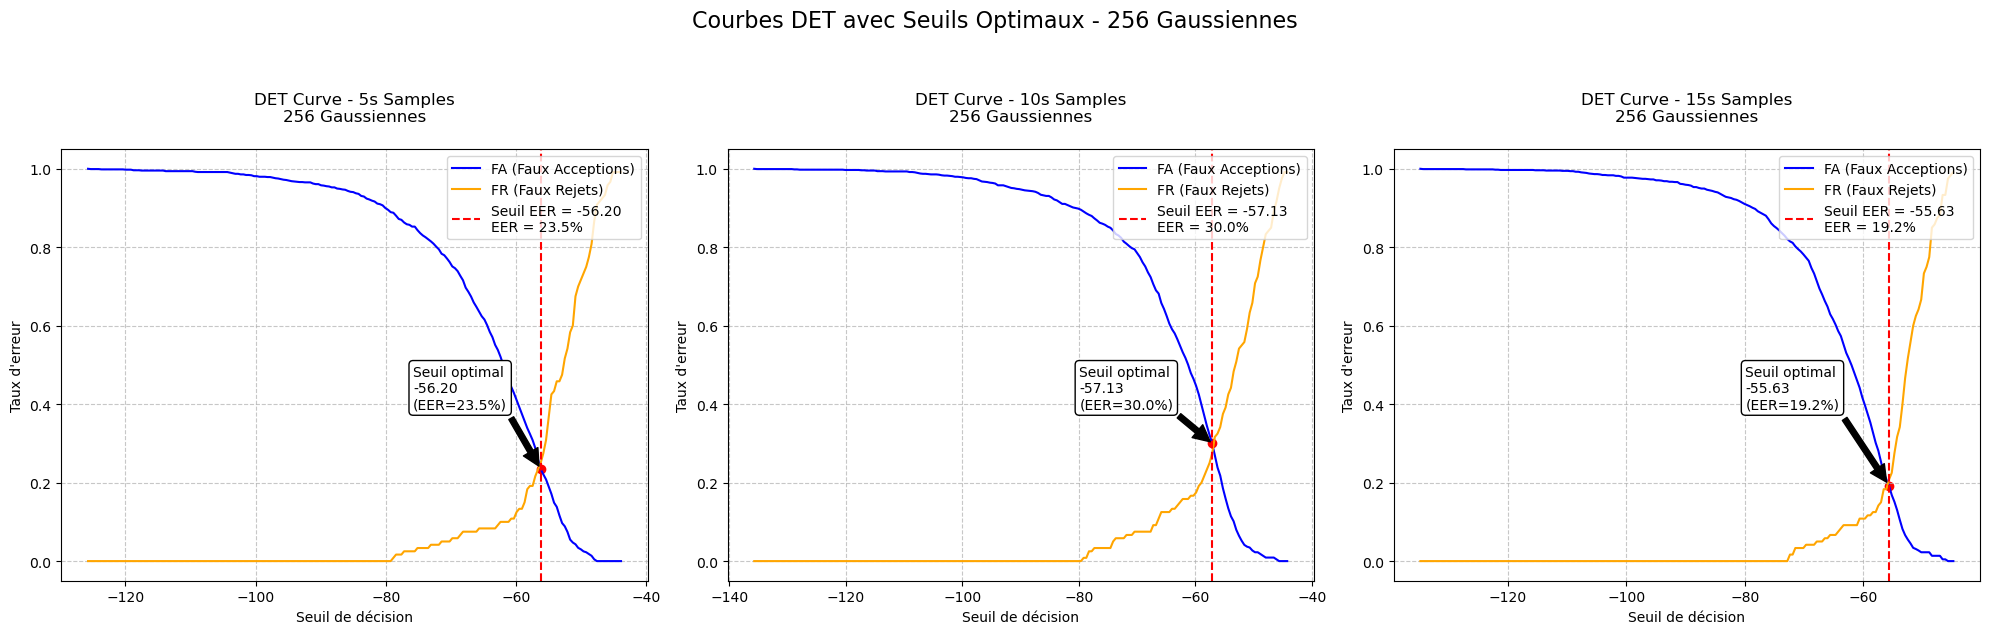

In [144]:
plot_dets_for_gmm(256)  

In [152]:
def create_performance_tables():
    gmm_configs = [8, 16, 32, 64, 128, 256]
    durations = ["5s", "10s", "15s"]
    files = ["test_results2_5s.xlsx", "test_results2_10s.xlsx", "test_results2_15s.xlsx"]
    
    # Initialize empty DataFrames
    eer_df = pd.DataFrame(index=gmm_configs, columns=durations)
    seuils_df = pd.DataFrame(index=gmm_configs, columns=durations)
    
    for gmm in gmm_configs:
        for duration, file in zip(durations, files):
            try:
                seuils, FPR, FNR = compute_det_data(file, gmm)
                diff = np.abs(np.array(FPR) - np.array(FNR))
                idx_eer = np.argmin(diff)
                
                # Store values
                eer_df.loc[gmm, duration] = FPR[idx_eer]
                seuils_df.loc[gmm, duration] = seuils[idx_eer]
            except Exception as e:
                print(f"Error processing {file} for {gmm} Gaussians: {str(e)}")
                eer_df.loc[gmm, duration] = np.nan
                seuils_df.loc[gmm, duration] = np.nan
    
    # Format the tables
    eer_df_styled = (eer_df.style
                    .format("{:.3f}")
                    .set_caption("EER Values by Configuration")
                    .background_gradient(cmap='Blues'))
    
    seuils_df_styled = (seuils_df.style
                       .format("{:.2f}")
                       .set_caption("Optimal Thresholds by Configuration")
                       .background_gradient(cmap='Greens'))
    
    return eer_df, seuils_df, eer_df_styled, seuils_df_styled

# Generate and display the tables
eer_table, seuils_table, eer_styled, seuils_styled = create_performance_tables()

print("EER Table (Lower is better):")
display(eer_styled)

print("\nOptimal Thresholds Table:")
display(seuils_styled)

# Optionally save to Excel
with pd.ExcelWriter('performance_metrics.xlsx') as writer:
    eer_table.to_excel(writer, sheet_name='EER_Values')
    seuils_table.to_excel(writer, sheet_name='Optimal_Thresholds')

EER Table (Lower is better):


,5s,10s,15s
8,0.271,0.307,0.230
16,0.248,0.307,0.208
32,0.250,0.301,0.218
64,0.240,0.298,0.205
128,0.247,0.280,0.196
256,0.235,0.300,0.192



Optimal Thresholds Table:


,5s,10s,15s
8,-52.45,-52.69,-52.08
16,-52.48,-52.89,-52.14
32,-52.77,-53.28,-52.55
64,-53.24,-53.85,-52.96
128,-54.45,-54.82,-53.92
256,-56.20,-57.13,-55.63
